In [1]:
"Hello World ! token : 81kncisgj5l"
"ZINDI SPOT THE MASK CHALLENGE Starter Notebook with TF.Keras"
"Read more here ::  https://zindi.africa/competitions/zindiweekendz-learning-spot-the-mask-challenge/  "

'Hello World ! token : 81kncisgj5l'

# Setup Environment


## Install and Import libraries

In [2]:
!nvidia-smi

Tue Jul 21 20:29:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# ignoring warnings
import warnings
warnings.simplefilter('ignore')

# for Colab link with Drive
from google.colab import drive

# for the directories and files operations & for system operations
import os

# for operations on images 
import cv2 

# for some maths operations
import math
import random
import numpy as np
import pandas as pd

# Machine learning libs
from sklearn.model_selection import StratifiedKFold

#Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Dense, Dropout, Flatten,Conv2D, GlobalAveragePooling2D, BatchNormalization)
from tensorflow.keras.optimizers import (SGD, Adam, RMSprop)
from tensorflow.keras.callbacks import (ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler)

# others ibraries
from tqdm.notebook import tqdm # for progressBar

from matplotlib import pyplot as plt # for visualization

In [4]:
tf.__version__

'2.2.0'

## Setup Environment

In [5]:
REPO_PATH = "drive/My Drive/REPOSITORIES/ZINDI-CHALLENGES/TUTORIAL:SPOT-THE-MASK-CHALLENGE/"

if REPO_PATH not in str(os.getcwd()) :
    drive.mount('/content/drive')

    os.chdir(REPO_PATH)
    print(f"Drive mounted at {os.getcwd()}") 
else:
    print(f"Drive already mounted at {os.getcwd()}") 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Drive mounted at /content/drive/My Drive/REPOSITORIES/ZINDI-CHALLENGES/TUTORIAL:SPOT-THE-MASK-CHALLENGE


In [6]:
PATH = \
{
    "CSV" : os.path.join( "DATASET", "CSV",  ),
    "IMAGES" : os.path.join( "DATASET", "IMAGES",  ),
    "train" : os.path.join( "DATASET", "IMAGES", "train" ),
    "no_mask" : os.path.join( "DATASET", "IMAGES", "train", "0-NO_MASK" ),
    "mask" : os.path.join( "DATASET", "IMAGES", "train", "1-MASK" ),
    "test" : os.path.join( "DATASET", "IMAGES", "test" ),
    "MODELS" : os.path.join( "MODELS", ),
    'SUBMISSIONS' : os.path.join("SUBMISSIONS")
} 

In [7]:
SEED = 1999

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load & Explore the Dataset

In [9]:
def processing_state( state="training", fold=0 ):

    if state == "start" :
        print(f"{'_'*150}\n{'-'*150}")
        star_msg = f'PROCESSING OF FOLD {fold +1} STARTED'
        print(f"{' ':>30}{'#'*30} {star_msg:^30.30} {'#'*30} ")
        print(f"{'_'*150}\n{'-'*150}\n")


    elif state == "training" :
        msg = f'TRAINING'
        print(f"\n{' ':>50}{'-'*10} {msg:^30.30} {'-'*10} \n")


    elif state == "predict" :
        msg = f'PREDICTION'
        print(f"\n{' ':>50}{'-'*10} {msg:^30.30} {'-'*10} \n")


    elif state == "end" :
        print(f"{'_'*150}\n{'-'*150}")
        end_msg = f'PROCESSING  FINISHED'
        print(f"{' ':>30}{'#'*30} {end_msg:^30.30} {'#'*30} ")
        print(f"{'_'*150}\n{'-'*150}\n")


def get_df():

    data = []

    for dirname, _, filenames in tqdm( os.walk(PATH['IMAGES']) ):
        for filename in filenames:
            filepath = os.path.join(dirname, filename)
            target = os.path.split(dirname)[-1]
            data += [{'image' : filename, 'filepath' : filepath, 'target' : target  }]
    
    return pd.DataFrame(data)

In [10]:
global_df = get_df()

test_condition = global_df.target == "test"
mask_condition = global_df.target == "1-MASK"
no_mask_condition = global_df.target == "0-NO_MASK"

In [11]:
train = global_df[~test_condition].reset_index(drop=True)
classes = train.target.unique().tolist()

mask_df = global_df[mask_condition].reset_index(drop=True) # not used to any processing
no_mask_df = global_df[no_mask_condition].reset_index(drop=True) # not used to any processing

sub = global_df[test_condition].reset_index(drop=True)

In [12]:
train.head()

,image,filepath,target
0,uxykipqshvpliunxlldynrpskpdzeu.png,DATASET/IMAGES/train/1-MASK/uxykipqshvpliunxll...,1-MASK
1,kpcznzbgvgwliaqhkcrwsusssykqvs.jpg,DATASET/IMAGES/train/1-MASK/kpcznzbgvgwliaqhkc...,1-MASK
2,bpwzubqeojttiklnrskmqheackknsn.jpg,DATASET/IMAGES/train/1-MASK/bpwzubqeojttiklnrs...,1-MASK
3,sczhdwamqbmpolozkmncxyqtcwcbdd.jpg,DATASET/IMAGES/train/1-MASK/sczhdwamqbmpolozkm...,1-MASK
4,uzewooxjwzphkroseskteuzyuzjgrr.jpg,DATASET/IMAGES/train/1-MASK/uzewooxjwzphkroses...,1-MASK


In [13]:
def process_df_train_dataset( train, bs, fold, classes ):    
    
    df_train = train[train.fold != fold].reset_index(drop=True)  

    fold_samples_by_clasees = dict(df_train.target.value_counts())
    max_n_samples =  np.array(list(fold_samples_by_clasees.values())).max()
    dict_df_of_classes = {}

    for (class_, n_samples) in fold_samples_by_clasees.items():
        if (n_samples != max_n_samples ):
            to_add_samples = max_n_samples - n_samples

            samples = df_train[ df_train.target == class_ ].sample(n=to_add_samples, random_state=SEED)
            df_train = pd.concat( [df_train, samples] ).reset_index(drop=True)
            

        if (max_n_samples * len(classes)) % bs != 0 :
            
            n_missing_samples_per_class = bs - (((max_n_samples * len(classes)) % bs) // len(classes))
            
            samples_class = df_train[ df_train.target == class_ ].sample(n=n_missing_samples_per_class, random_state=SEED)
            dict_df_of_classes[class_] = pd.concat( [df_train[ df_train.target == class_ ], samples_class] ).reset_index(drop=True)

    return dict_df_of_classes

In [14]:
def df_to_gen( df, batch_size ):
    return train_datagen.flow_from_dataframe(df, x_col='filepath', y_col='target',target_size=size,
                                    classes=classes,class_mode='categorical',shuffle=True,
                                    batch_size=batch_size, seed=SEED,)# batch_size=bs//len(classes) 
    
def gen_to_ds( gen, ):
    return tf.data.Dataset.from_generator(lambda: gen, 
                                (tf.float32, tf.float32),
                                (tf.TensorShape([None, None, None, 3]), tf.TensorShape([None, 2])),)
    
def get_train_ds(batch_size=8 , buffer_size = 8):
    
    batch_size = batch_size//len(classes)
    train_generators = []

    for df in dict_classes_df_train.values() : 
        train_generators.append( gen_to_ds( df_to_gen( df, batch_size ) ) )
    
    ds = tf.data.Dataset.zip(tuple(train_generators)).map(lambda x1, x2 : 
                (tf.concat( [ x1[0], x2[0] ], axis=0),
                tf.concat( [ x1[1], x2[1] ], axis=0) ),
                num_parallel_calls=tf.data.experimental.AUTOTUNE,
                deterministic=True).prefetch(buffer_size = buffer_size)

    return ds

# Visualization

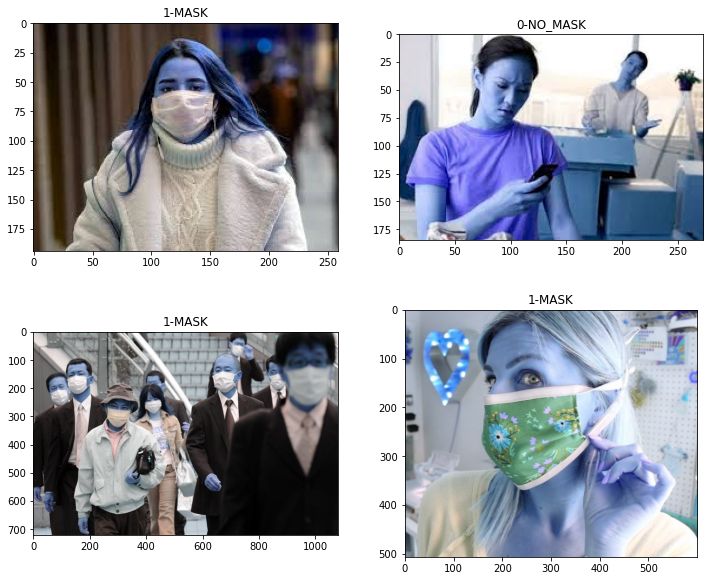

In [15]:
#Training images
nrows = 2
rands = np.random.randint(train.shape[0], size=nrows**2)
fig = plt.figure(figsize=(12,10))

for i in range(nrows**2):
    img = cv2.imread(train.loc[rands[i], 'filepath'])
    ax = plt.subplot(nrows, nrows, i+1)
    plt.imshow(img)
    plt.title(train.loc[rands[i], 'target'])
plt.show()

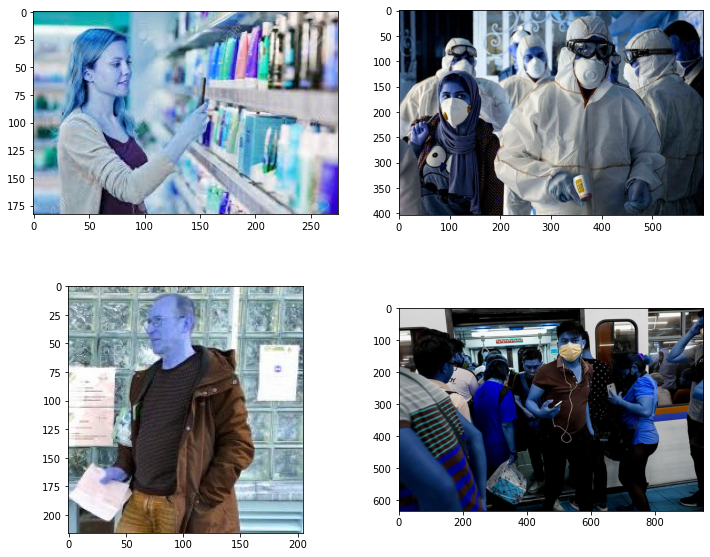

In [16]:
#Test images
nrows = 2
rands = np.random.randint(sub.shape[0], size=nrows**2)
fig = plt.figure(figsize=(12,10))

for i in range(nrows**2):
    img = cv2.imread(sub.loc[rands[i], 'filepath'])
    ax = plt.subplot(nrows, nrows, i+1)
    plt.imshow(img)
plt.show()

# Modeling

In [17]:
from tensorflow.keras.applications import ResNet50, Xception
# from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.xception import preprocess_input


In [18]:
def BuildModel (pretrained=Xception ,num_classes=len(classes)):

    conv_base = pretrained(include_top=False, weights='imagenet')

    for layer in conv_base.layers:
        layer.trainable = False

    x = conv_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = Dense(4086, activation='relu',  )(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(conv_base.input, predictions)
    
    return model


In [19]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input,
    width_shift_range=0.1,
    height_shift_range=0.1,
    channel_shift_range=10.,
    )

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    )


# Training

## Prepare Folds

In [20]:
train['fold'] = 'nan'

n_folds = 10

skfold = StratifiedKFold(n_splits = n_folds, shuffle=True, random_state=SEED)
fold_samples_by_clasees = {}

for class_ in classes :

    for i, (tr, vr) in enumerate(skfold.split(train[ train.target == class_ ], train[ train.target == class_ ]['target'])):
        indexes = train[ train.target == class_ ].index
        train.loc[indexes[vr], 'fold'] = i


## Train on Folds

In [ ]:
bs = 32 # 2**n  
size = (224, 224)
lr = 1e-4

folds_predictions = pd.DataFrame()
test_ds = val_datagen.flow_from_dataframe(sub, x_col='filepath',target_size=size, class_mode=None,shuffle=False,batch_size=bs,)


for fold in range(n_folds):
    processing_state( state="start", fold=fold )

    df_val = train[train.fold == fold].reset_index(drop=True)
    val_ds = val_datagen.flow_from_dataframe(df_val, x_col='filepath', y_col='target',target_size=size,classes=classes,class_mode='categorical',shuffle=False,
                                            batch_size=bs,)

    dict_classes_df_train = process_df_train_dataset( train, bs, fold, classes )
    train_ds_size = list(dict_classes_df_train.values())[0].shape[0]*len(classes)

    # # Callbacks
    es = EarlyStopping(monitor='val_loss',mode='auto',verbose=1,restore_best_weights=True,patience=5)
    # lr_reducer = ReduceLROnPlateau(monitor='val_loss', patience=11, verbose=1, factor=0.7, min_lr=1e-8)
    chkpt_path = os.path.join(PATH["MODELS"], f"Keras_Model_{fold}.h5", )
    checkpoint = ModelCheckpoint(chkpt_path, monitor='val_loss',mode='auto', verbose=1, save_best_only=True,)

    model = BuildModel()
    optimizer = keras.optimizers.Adam(lr=lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    ds = get_train_ds(batch_size=bs, buffer_size=28 )

    processing_state( state="training", )
    history = model.fit(ds, epochs=15, batch_size=bs, steps_per_epoch=( train_ds_size // bs ) , 
                        callbacks=[es,checkpoint], verbose=1 ,shuffle=False,
                        validation_data=(val_ds), validation_steps= np.ceil(len(df_val) / bs )  ,)
    
    processing_state( state="predict",)
    predictions = model.predict(test_ds, steps=np.ceil(len(sub) / bs) )
    folds_predictions[fold]  = predictions[:, 1] 
    processing_state( state="end",)

Found 509 validated image filenames.
______________________________________________________________________________________________________________________________________________________
------------------------------------------------------------------------------------------------------------------------------------------------------
                              ##############################  PROCESSING OF FOLD 1 STARTED  ############################## 
______________________________________________________________________________________________________________________________________________________
------------------------------------------------------------------------------------------------------------------------------------------------------

Found 132 validated image filenames belonging to 2 classes.
83689472/83683744 [==============================] - 1s 0us/step
Found 624 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 

# Submission

In [ ]:
n_submit = "1st"

In [ ]:
submission = pd.DataFrame()
submission['image'] = sub['image']
submission['target'] = folds_predictions.mean(axis=1)

folds_preds_path = os.path.join( PATH['SUBMISSIONS'], f'keras_{n_submit}_folds_predictions.csv' )
submission_path = PATH['SUBMISSIONS'], f'keras_{n_submit}_submission.csv' )

folds_predictions.to_csv( folds_preds_path , index=False )
submission.to_csv( os.path.join( submission_path , index=False )

print(f"[INFO] Storage file of folds predictions created : {folds_preds_path} ")
print(f"[INFO] Submission file created : {submission_path} ")

In [ ]:
########################################################################### THE END ########################################################################